<a href="https://colab.research.google.com/github/simritha14/JOD-DS/blob/main/PROJECT_CLUSTERING_SIMRITHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmenting Customers into Clusters - SIMRITHA R

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/customer_dataset.xlsx")

In [ ]:
# Viewing the shape of dataframe
data.shape

(541909, 8)

In [ ]:
# Viewing the first 5 rows of dataframe
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## DATA PREPARATION

In [ ]:
# Viewing the datatypes of dataframe columns
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [ ]:
# Viewing the percentage of missing values in dataframe
data.isnull().sum()/len(data.InvoiceNo)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

* Since there is a lot of missing values we will drop those rows usinf dropna() because in transactional data we cannot replace the Customer ID with its mode.

In [ ]:
data = data.dropna()
data.shape

(406829, 8)

## RFM TABLE

There are several metrics that we can use to segment customers, such as when the customer last bought the product, how frequently the consumer buys the product, and how much the customer pays for the product. This segmentation will be referred to as RFM segmentation.

These columns, such as Recency, Frequency, and Monetary Value, can be added to the RFM table.
* We can get the number of days for the recency column by subtracting the snapshot date from the transaction date.
* We may count how many transactions each client has to construct the frequency column.
* Finally, we can total all transactions for each client to create the monetary value column.

In [ ]:
# Convert to show date only
data["InvoiceDate"] = data["InvoiceDate"].dt.date

In [ ]:
# Create Total sum colummn
data["TotalSum"] = data["Quantity"] * data["UnitPrice"]

In [ ]:
import datetime
# Create date variable that records recency
last_date = max(data.InvoiceDate) + datetime.timedelta(days=1)

In [ ]:
# Aggregate data by each customer
customers = data.groupby(['CustomerID']).agg({'InvoiceDate': lambda a: (last_date - a.max()).days,'InvoiceNo': 'count','TotalSum': 'sum'})

In [ ]:
# Rename the columns
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency','TotalSum': 'MonetaryValue'}, inplace=True)

In [ ]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


## MANAGING SKEWNESS

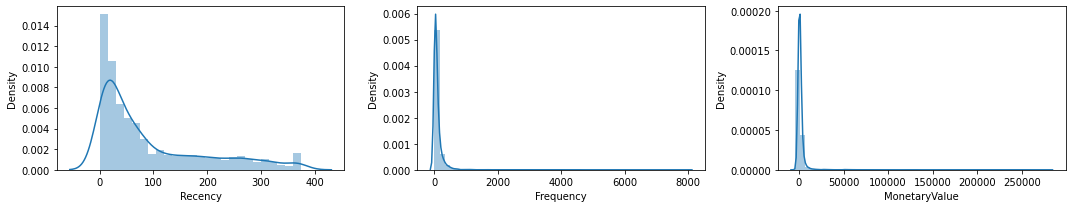

In [ ]:
# visualizing the variables
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

* As we can see from the diagrams above, we need to alter the data to make it more symmetrical.

There are some methods that we can use to manage the skewness, they are,
* log transformation
* square root transformation
* box-cox transformation

In [ ]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

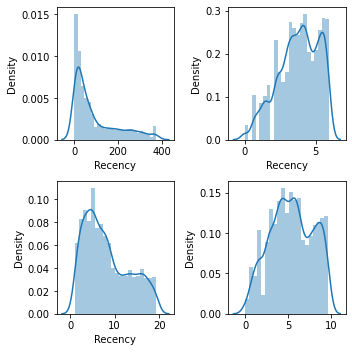

1.25
-0.45
0.6
-0.07


In [ ]:
analyze_skewness('Recency')

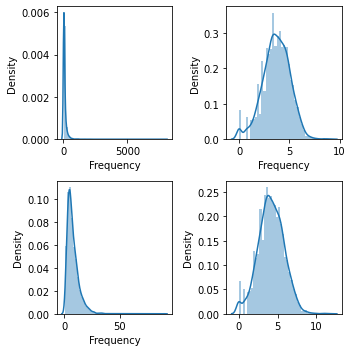

18.15
-0.24
3.2
0.0


In [ ]:
analyze_skewness('Frequency')

* In comparison to the previous transformations, the box-cox transformation has a more symmetrical form. With the exception of the MonetaryValue variable, which contains negative values. We can employ cubic root transformation on the data to deal with this variable.

In [ ]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.head()

,Recency,Frequency,MonetaryValue
0,9.314966,0.707055,0.000000
1,1.196521,6.060363,16.273929
2,6.146603,3.794006,12.158183
3,3.721132,4.862047,12.068017
4,9.201025,3.075409,6.941001


## SCALING

The data needs to be normalised to perform the KMeans modeling since its a distance based moseling process. We may use the StandardScaler object from the scikit-learn module to normalise.

In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler
customers_normalized= customers_fix[['Recency','Frequency','MonetaryValue']]
# instantiate
scaler = StandardScaler()
# fit_transform
customers_normalized = scaler.fit_transform(customers_normalized)
customers_normalized = pd.DataFrame(customers_normalized)

In [ ]:
customers_normalized.columns = ['Recency','Frequency','MonetaryValue']
customers_normalized.head()

,Recency,Frequency,MonetaryValue
0,1.606608,-2.098072,-1.925647
1,-1.696240,1.151346,1.330542
2,0.317615,-0.224316,0.507038
3,-0.669146,0.423978,0.488997
4,1.560253,-0.660498,-0.536848


## K-MEANS

* The Kmeans algorithm is an iterative method for dividing a dataset into K separate groups. 
* It attempts to make intra-cluster data points as comparable as possible while maintaining clusters as far apart as possible. 
* It assigns data points to a cluster so that the sum of their squared distances from the cluster's centroid is as small as possible. 
* Within clusters, the less variance there is, the more uniform the data points are.

In [ ]:
# importing KMeans
from sklearn.cluster import KMeans

In [ ]:
# k-means with kvalue = 4
kmodel= KMeans(n_clusters=4)
# fitting the model
kmodel.fit(customers_normalized)

KMeans(n_clusters=4)

In [ ]:
# predicting
pred=kmodel.predict(customers_normalized)
pd.Series(pred).value_counts()

1    1368
3    1249
2    1063
0     692
dtype: int64

In [ ]:
# finding the inertia
kmodel.inertia_

4741.963380908517

In [ ]:
# finding the score
kmodel.score(customers_normalized)

-4741.963380908516

## ELBOW CURVE

* One of the most prominent approaches for determining the ideal value of k is the Elbow Method.

In [ ]:
# using the range as 1 - 20
SSE = []
for cluster in range(1,20):
  kmodel = KMeans(n_clusters = cluster)
  kmodel.fit(customers_normalized)
  SSE.append(kmodel.inertia_)   

In [ ]:
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})

Text(0, 0.5, 'SSE')

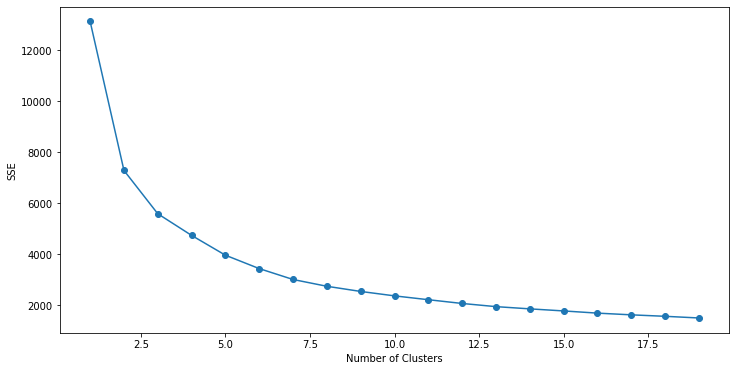

In [ ]:
# Elbow curve
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')


* Because the next k-value tends to have a linear trend, the k-value of 5 is the optimal for our model. As a result, the best model for the data is K-Means with five clusters.

## FINAL K-MEANS

In [ ]:
# importing KMeans
from sklearn.cluster import KMeans

In [ ]:
# k-means with k value 5
kmodel= KMeans(n_clusters=5)

# fitting with new model
kmodel.fit(customers_normalized)

KMeans(n_clusters=5)

In [ ]:
# predicting
pred=kmodel.predict(customers_normalized)

In [ ]:
# Calculating the inertia
kmodel.inertia_

3969.1391177864143

In [ ]:
# Calculating the score
kmodel.score(customers_normalized)

-3969.1391177864143

## INTERPRETING THE SEGMENTS

In [ ]:
customers_normalized["Cluster"] = pred


In [ ]:
customers["Cluster"] = pred

In [ ]:
customers_normalized.head()

,Recency,Frequency,MonetaryValue,Cluster
0,1.606608,-2.098072,-1.925647,3
1,-1.696240,1.151346,1.330542,2
2,0.317615,-0.224316,0.507038,0
3,-0.669146,0.423978,0.488997,2
4,1.560253,-0.660498,-0.536848,3


* The RFM table can be summarised using clusters, and the mean of each variable can be calculated.

In [ ]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        113.71     72.19       1154.49   999
1         30.22     26.56        468.66  1021
2         17.09    167.39       2353.44  1074
3        220.70     13.80        271.70  1085
4         12.93    584.68      19926.63   193

**TYPES OF CUSTOMERS :**

* **Cluster 0** - Not Frequent, did not spend much and did not visit for a long time - ***LOST CUSTOMER***

* **Cluster 3** - one in a while, not frequent, average spendings - ***AT RISK CUSTOMER***

* **Cluster 1**	- recent, less frequent, less spendings - ***NEW CUSTOMER***

* **Cluster 2** - very recent, frequent, average shopper - ***LOYAL CUSTOMER***

* **Cluster 4** - most recent, very frequent, heavy shopper - ***BEST CUSTOMER***


* We can also use a 3D scatter plot to study the segments. We can get a decent visual representation of how the clusters differ from one another by utilising this plot.

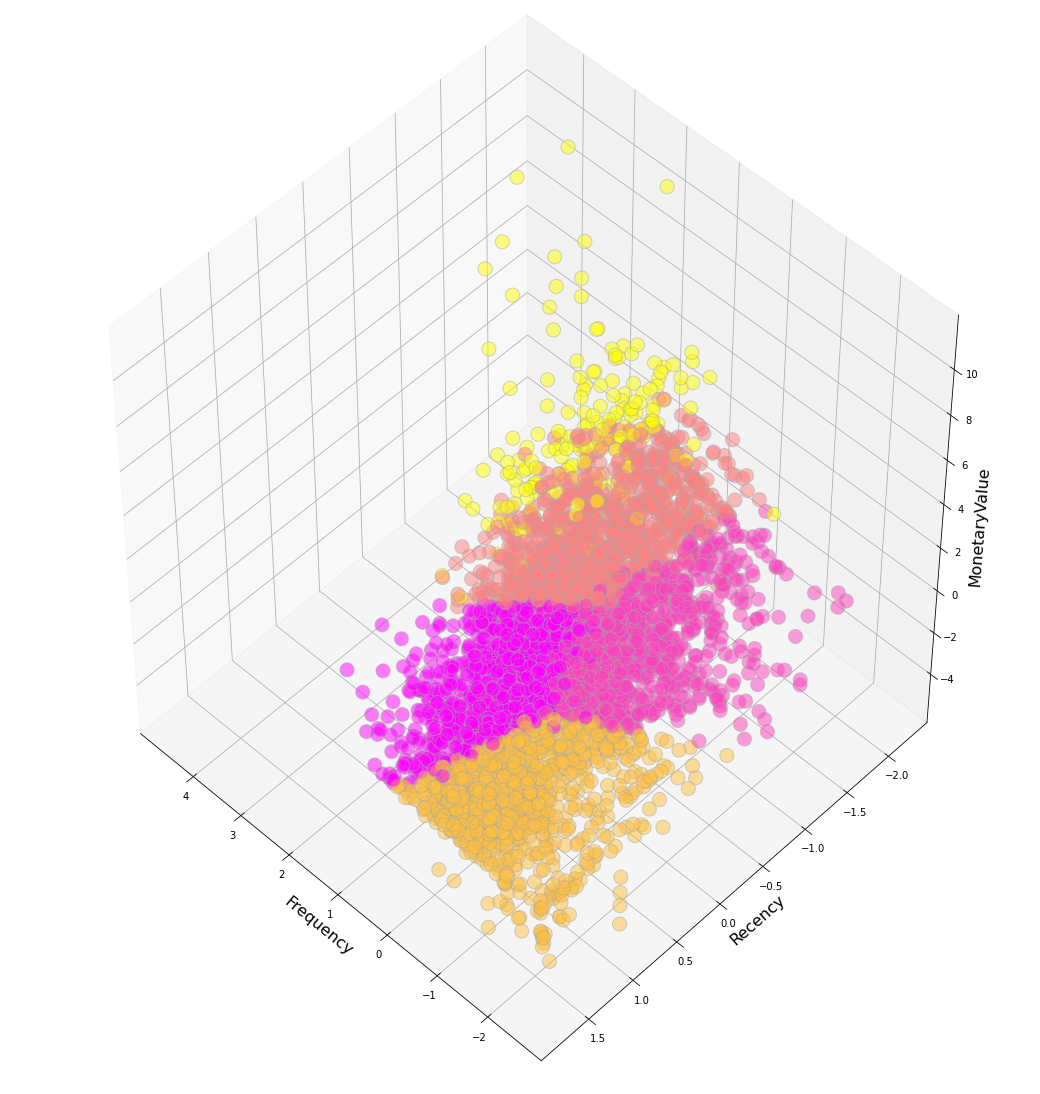

In [ ]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (15,15)
fig=plt.figure(1)
plt.clf()
ax = Axes3D(fig,
            rect = [0, 0, .95, 1],
            elev = 48,
            azim = 134)
plt.cla()
ax.scatter(customers_normalized['Frequency'], 
           customers_normalized[ 'Recency'],
           customers_normalized['MonetaryValue'],
           c = customers_normalized['Cluster'],
           s = 200,
           cmap= 'spring',
           alpha = 0.5,
           edgecolor='darkgrey')

ax.set_xlabel('Frequency',
              fontsize =16)
ax.set_ylabel('Recency',
              fontsize =16)
ax.set_zlabel('MonetaryValue',
              fontsize =16)
plt.show()
